# Goals

1. Load data matrix
2. Plot bars using drop down select

## 1. Load data matrix

In [1]:
# repurposing code from 1.1_gc_metabolomics_PCA.ipynb
# Import create_engine
from sqlalchemy import create_engine, MetaData, Table, select, join
import pandas as pd

# SQLite path
db_path = 'sqlite:///../../../data/SQLite Database/Covid-19 Study DB.sqlite'

# Create an engine that connects to the Covid-19 Study DB.sqlite file: engine
engine = create_engine(db_path)

# Establish connection
connection = engine.connect()

# pull table into df
metabolomics_measurements_df = pd.read_sql_query("SELECT * from metabolomics_measurements", connection)

# pull table into df
metabolomics_runs_df = pd.read_sql_query("SELECT * from metabolomics_runs", connection)

# pull table into df
rawfiles_df = pd.read_sql_query("SELECT * from rawfiles WHERE ome_id=3 AND sample_ID<>-1 and keep=1", connection)

# pull table into df
deidentified_patient_metadata_df = pd.read_sql_query("SELECT * from deidentified_patient_metadata", connection)

# make sure the merge by columns are all the same type -> pandas seems sensitive to this
metabolomics_measurements_df = metabolomics_measurements_df.astype({'replicate_id': 'int32'})
metabolomics_runs_df = metabolomics_runs_df.astype({'replicate_id': 'int32', 'rawfile_id': 'int32'})
rawfiles_df = rawfiles_df.astype({'rawfile_id': 'int32', 'sample_id': 'int32'})
deidentified_patient_metadata_df = deidentified_patient_metadata_df.astype({'sample_id': 'int32'})

joined_df = metabolomics_measurements_df\
            .join(metabolomics_runs_df.set_index('replicate_id'), on='replicate_id')\
            .join(rawfiles_df.set_index('rawfile_id'), on='rawfile_id')\
            .join(deidentified_patient_metadata_df.set_index('sample_id'), on='sample_id')
joined_df.head()

wide_df = joined_df.pivot_table(index='sample_id', columns='biomolecule_id', values='normalized_abundance')
wide_df.head()

biomolecule_id,1,2,3,4,5,6,7,8,9,10,...,206,207,208,209,210,211,212,213,214,215
sample_id,,,,,,,,,,,,,,,,,,,,,
1.0,21.309897,21.783308,22.687091,25.179914,21.630920,22.525987,10.453876,13.401977,11.735486,15.750871,...,11.735665,13.040251,12.276960,12.688793,17.169812,17.874240,12.808183,12.773660,15.037276,15.037276
2.0,21.221647,21.992647,23.610570,25.879197,19.130454,22.879847,12.930581,17.572637,12.743904,13.955800,...,13.523504,13.644353,13.343292,13.210456,13.352844,16.451434,13.200200,11.238030,17.255301,17.255301
3.0,21.905527,21.804050,23.092468,25.887330,12.570631,21.792056,12.698673,13.575324,12.576889,13.749587,...,13.145593,14.572374,12.980692,12.916020,20.310171,16.629386,13.528407,12.626464,15.841446,15.841446
4.0,21.398009,22.049826,23.324338,25.608685,18.225689,22.743837,13.183789,17.503154,13.101793,13.297381,...,13.150066,12.160665,12.567163,12.970315,12.525943,15.012600,13.594485,12.787116,16.246023,16.246023
5.0,20.810078,21.722431,22.867385,24.825837,18.028411,23.304373,12.809623,14.053167,12.051449,16.206185,...,10.887817,10.633127,12.489749,11.756084,16.983539,16.917784,13.370118,13.290696,16.177633,16.177633


## 2. Plot bars using drop down select

For a given biomolecule, plot the abundance across samples

https://dash.plotly.com/basic-callbacks

In [11]:
biomolecule_id = 4

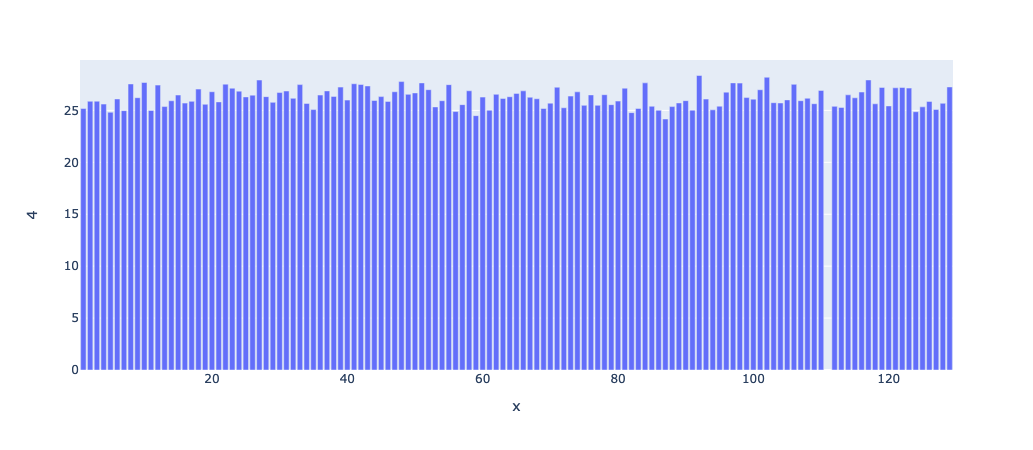

In [15]:
import plotly.express as px

fig = px.bar(wide_df, x=wide_df.index, y=biomolecule_id)

fig.show()

In [17]:
# get biomolecule names
biomolecules_df = pd.read_sql_query("SELECT * from biomolecules", connection)
biomolecules_df.head()

,biomolecule_id,standardized_name,omics_id,keep
0,1,unknown RT 4.081766,3,1
1,2,unknown RT 4.148561,3,1
2,3,unknown RT 5.261918,3,1
3,4,unknown RT 5.349937,3,1
4,5,unknown RT 5.462593,3,1


In [18]:
# build biomolecule name dict
biomolecule_name_dict = {}
for index, row in biomolecules_df.iterrows():
    biomolecule_id = row['biomolecule_id']
    standardized_name = row['standardized_name']
    biomolecule_name_dict[biomolecule_id] = standardized_name

In [19]:
# replace wide_df column names
new_col_names = []
for col in wide_df.columns:
    new_col_names.append(biomolecule_name_dict[col])

In [20]:
wide_df.columns = new_col_names

In [21]:
wide_df

,unknown RT 4.081766,unknown RT 4.148561,unknown RT 5.261918,unknown RT 5.349937,unknown RT 5.462593,"1,2-Propanediol, 2TMS derivative RT5.872253","1,2-Propanediol, 2TMS derivative RT5.931987",unknown RT 6.116922,unknown RT 6.143433,"2,3-Butanediol, 2TMS derivative RT6.321158",...,Sugar RT23.573516,unknown possibly Mycophenolic acid,unknown RT 23.674324,unknown RT 24.167976,unknown RT 24.557433,Cholesterol derivative RT25.501888,Sugar RT26.882393,unknown RT 27.639949,Sugar RT28.077994,Sugar RT28.077994_Duplicate
sample_id,,,,,,,,,,,,,,,,,,,,,
1.0,21.309897,21.783308,22.687091,25.179914,21.630920,22.525987,10.453876,13.401977,11.735486,15.750871,...,11.735665,13.040251,12.276960,12.688793,17.169812,17.874240,12.808183,12.773660,15.037276,15.037276
2.0,21.221647,21.992647,23.610570,25.879197,19.130454,22.879847,12.930581,17.572637,12.743904,13.955800,...,13.523504,13.644353,13.343292,13.210456,13.352844,16.451434,13.200200,11.238030,17.255301,17.255301
3.0,21.905527,21.804050,23.092468,25.887330,12.570631,21.792056,12.698673,13.575324,12.576889,13.749587,...,13.145593,14.572374,12.980692,12.916020,20.310171,16.629386,13.528407,12.626464,15.841446,15.841446
4.0,21.398009,22.049826,23.324338,25.608685,18.225689,22.743837,13.183789,17.503154,13.101793,13.297381,...,13.150066,12.160665,12.567163,12.970315,12.525943,15.012600,13.594485,12.787116,16.246023,16.246023
5.0,20.810078,21.722431,22.867385,24.825837,18.028411,23.304373,12.809623,14.053167,12.051449,16.206185,...,10.887817,10.633127,12.489749,11.756084,16.983539,16.917784,13.370118,13.290696,16.177633,16.177633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125.0,21.717839,21.199616,22.814710,25.340861,19.365934,22.871919,13.079537,13.666417,12.101021,15.508293,...,13.035087,12.672107,12.797433,13.068042,12.862235,16.626568,13.724262,14.738471,17.016293,17.016293
126.0,22.026375,21.318946,22.831807,25.865796,17.951237,21.440177,11.775681,17.808692,12.604064,13.658463,...,12.337837,18.665645,12.583670,12.881798,20.619348,16.576569,13.356697,12.078360,18.009642,18.009642
127.0,20.440768,21.778698,22.952819,25.094374,16.093479,22.357201,13.026523,14.016694,13.029534,15.977306,...,13.441363,13.300513,13.127588,13.139711,13.314418,16.191941,13.900984,13.052785,17.290952,17.290952
